<center><h1> Service 5: Grassland Mowing Detection Using ADC for CAP monitoring</h1></center>

<img src='https://www.fao.org/3/y8344e/y8344e21.jpg'/>

## Description

<p> Grasslands have significant enviromental value since they have direct impact on animal biodiversity, food production and global carbon cycle. Moreover, they cover more than 40% of global agricultural land. For these reasons and several more, the Common Agricultural Policy (CAP) aims on suitable measures in order to ensure their ecological necessity and shield their vulnerability. The effortless and accurate monitoring and management of grasslands activity can contribute without a doubt into the proper enaction of such measures </p>

## Data

Satellite imagery from the EU Copernicus Sentinel-1 and Sentinel-2 missions are used, resampled in 10m resolution as well as parcels geometries.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors as mcolours
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap,BASE_COLORS,CSS4_COLORS
import seaborn as sns
from datetime import datetime,timedelta
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


from utils import *

# Paths and Parameters

In [2]:
buffer = 'buffer5'
path_decl = '/home/eouser/Desktop/jason_notebooks/for_thanassis_GIT_new/mowing_example/data/lithuania_declarations_2020_3857_sample.shp'
shapefile_bbox = '/home/eouser/Desktop/jason_notebooks/for_thanassis_GIT_new/mowing_example/data/lithuania_bbox_sample_area_3857.shp'
optical_bands = ['ndvi']

start_date,end_date = '2020-04-01','2020-09-15'

### Applicants Declarations Sample Shapefile

In [3]:
dbf = gpd.GeoDataFrame.from_file(path_decl)
print(dbf.shape)
dbf.head()

(18683, 4)


,Decl_Code,Decl_Area,Parcel_ID,geometry
0,DGP,1.47,1770,"POLYGON ((2659880.383 7261590.846, 2659864.729..."
1,DGP,0.52,3014,"POLYGON ((2630310.573 7244059.631, 2630305.289..."
2,ŽIR,0.62,65940,"POLYGON ((2629049.847 7232169.305, 2629041.113..."
3,DGP,0.55,65941,"POLYGON ((2628999.248 7232403.099, 2629062.476..."
4,DGP,0.40,65942,"POLYGON ((2629406.342 7235127.197, 2629416.180..."


In [4]:
df = pd.read_csv('/home/eouser/Desktop/jason_notebooks/for_thanassis_GIT_new/mowing_example/data/lithuania_codes.csv')
df.head()

,crop_code,crop_name
0,5PT-11,Other natural areas nursery and greenhouse
1,5PT-12,Other natural areas nursery and greenhouse
2,5PT-3,Other natural areas nursery and greenhouse
3,5PT-9,Other natural areas nursery and greenhouse
4,AI-1,Other natural areas nursery and greenhouse


### Crop codes merging into categories of more general level of taxonomy

In [5]:
code_to_name = {k[0]:k[1] for k in df.values}
dbf['Decl_Code'] = dbf['Decl_Code'].map(code_to_name)

In [6]:
cols = {}
cols['Spring cereal']='red'
cols['Corn']='blue'
cols['Spring cereal']='yellow'
cols['Potatoes']='darkorange'
cols['Black fallow']='purple'
cols['Grass']='green'

###KEEP ONLY THE CATEGORIES ABOVE

dbf = dbf[dbf.Decl_Code.isin(list(cols.keys()))].reset_index(drop=True)
dbf_i = dbf.copy()

### Some Explanatory Analysis

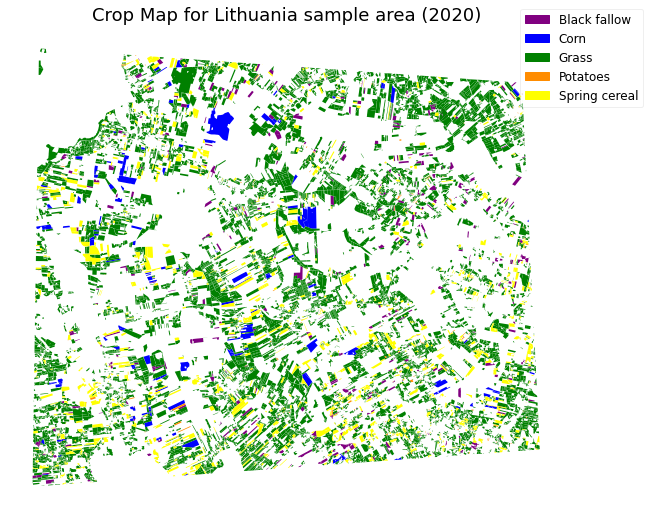

In [7]:
fig, axes = plt.subplots(1,1, figsize=(10, 10))
legend_elements = []
for group_1 in dbf_i[dbf_i['Decl_Code'].isin(dbf_i['Decl_Code'].value_counts().index)].groupby('Decl_Code'):
    
    group_1[1].plot(ax=axes,color=cols[group_1[0]], aspect=1)
    label = group_1[0]
    legend_elements.append(Patch(facecolor=cols[group_1[0]], edgecolor=cols[group_1[0]],label=label))

axes.set_axis_off()
axes.legend(handles=legend_elements,bbox_to_anchor=(1.15,1.05),fontsize=12,fancybox=True,framealpha=0.3)
axes.set_title('Crop Map for Lithuania sample area (2020)',fontsize=18)
plt.show()

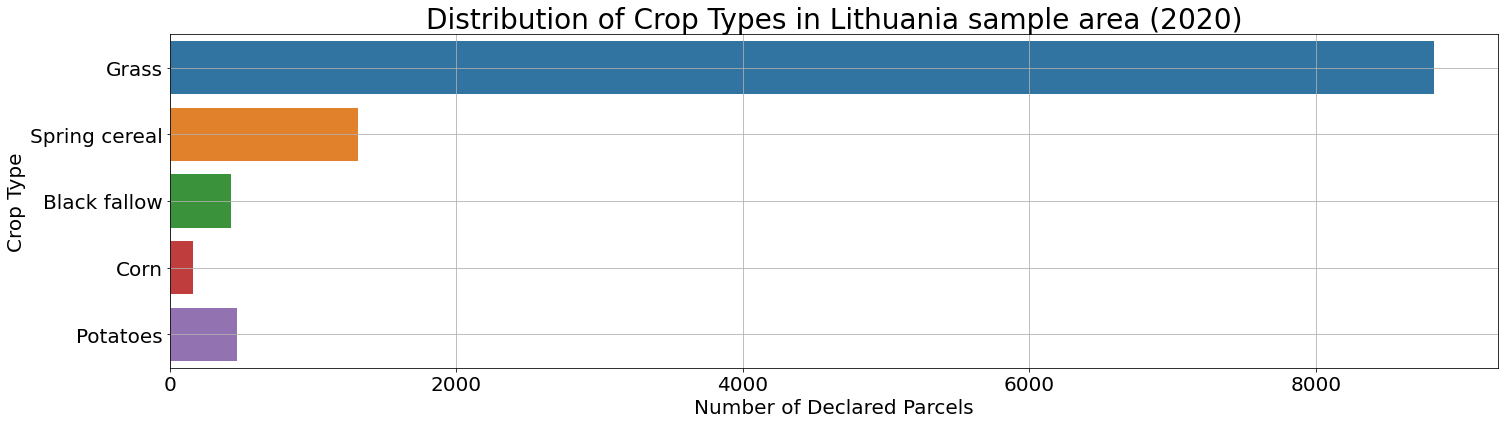

In [8]:
plt.figure(figsize=(21,6))
plt.title('Distribution of Crop Types in Lithuania sample area (2020)',fontsize=28)

sns.countplot(data=dbf_i,y = 'Decl_Code')
plt.ylabel('Crop Type',fontsize=20)
plt.xlabel('Number of Declared Parcels',fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.grid()

Size of parcels, as well as the shape, consist one of the major problems of precise monitoring since S2 resolution is 10m. As a results parcels of small area size (<0.2 hectares) have less than enough pixels in order to have representative information

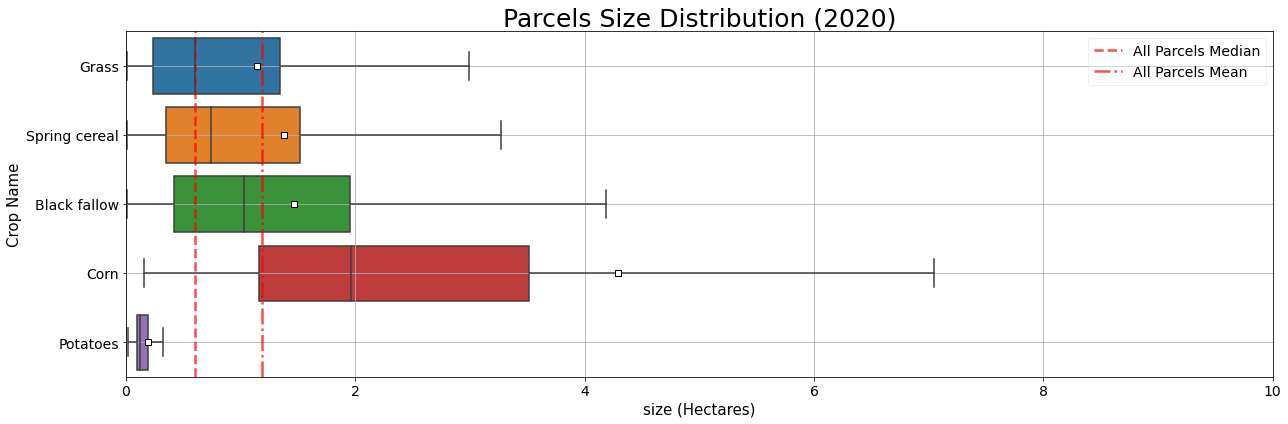

In [9]:
fig = plt.figure(figsize=(18,6))
ax = sns.boxplot(x='Decl_Area',y='Decl_Code',data=dbf_i,showfliers = False,whis=1.5,
                 showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})

ax.axvline(x=dbf_i.Decl_Area.median(),color='r',alpha=0.7,linewidth=2.5,linestyle='--',
           label='All Parcels Median')

ax.axvline(x=dbf_i.Decl_Area.mean(),color='r',alpha=0.7,linewidth=2.5,linestyle='-.',
           label='All Parcels Mean')

ax.tick_params(labelsize=14)
plt.title('Parcels Size Distribution (2020)',fontsize=25)
plt.xlim(0,10)
plt.xlabel('size (Hectares)',fontsize=15)
plt.ylabel('Crop Name',fontsize=15)
plt.grid()
plt.legend(fontsize=14,fancybox=True, framealpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
## FINALLY KEEP ONLY GRASSLAND CASES

dbf = dbf[dbf.Decl_Code=='Grass'].reset_index(drop=True)

## FS Creation using datacube utilities

In [11]:
%%time
ids,fs_mean,fs_std,dates = fs_creation(shapefile_bbox,start_date,end_date,optical_bands,
                                       buffer,ids_to_keep=dbf.Parcel_ID.values)

CPU times: user 10min 2s, sys: 2min 25s, total: 12min 27s
Wall time: 2min 5s


In [12]:
df = pd.DataFrame(columns=dates,data=fs_mean.reshape(len(ids),len(dates)))
df.columns = [datetime.strptime(k,'%Y-%m-%d') for k in df.columns]
print(df.shape)
df.head()

(8668, 55)


,2020-04-04,2020-04-06,2020-04-11,2020-04-14,2020-04-16,2020-04-19,2020-04-21,2020-04-24,2020-04-26,2020-04-29,...,2020-08-17,2020-08-19,2020-08-22,2020-08-24,2020-08-27,2020-09-01,2020-09-03,2020-09-06,2020-09-11,2020-09-13
0,NaN,0.585449,0.623047,0.421143,NaN,NaN,0.643555,NaN,NaN,NaN,...,0.786621,NaN,NaN,0.738770,NaN,NaN,0.378906,0.314209,NaN,NaN
1,NaN,0.282715,0.311768,0.351562,NaN,NaN,0.313232,NaN,NaN,NaN,...,0.701172,NaN,NaN,NaN,NaN,NaN,0.840820,0.781738,0.666504,NaN
2,NaN,0.454590,NaN,0.515625,NaN,NaN,0.473633,NaN,NaN,NaN,...,0.654785,NaN,0.349609,0.592773,NaN,NaN,0.642578,0.662598,0.202515,NaN
3,NaN,0.402588,0.429443,0.455322,NaN,NaN,0.423096,NaN,NaN,NaN,...,0.648438,NaN,NaN,NaN,NaN,NaN,0.650391,0.648438,NaN,NaN
4,NaN,0.432129,0.429688,0.484375,NaN,NaN,0.447754,NaN,NaN,NaN,...,0.673340,NaN,NaN,NaN,NaN,NaN,0.663574,0.667480,NaN,NaN


## Extra Cloud Filtering

<img src='https://forum.step.esa.int/uploads/default/original/2X/3/3a19e4d47f9114b9e087eb561aef8838372c34ac.png'/>

Unfortunately [sen2cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) that we are using here provides suboptimal performance, keeping several cloudy measurements that can wrongly be indicated as mowing events. For that reason, we have developed an additional <b>filtering routine</b> on top of datacube extracted FS that excludes measurements that exist between two consecutive negative and positive gaps of NDVI 

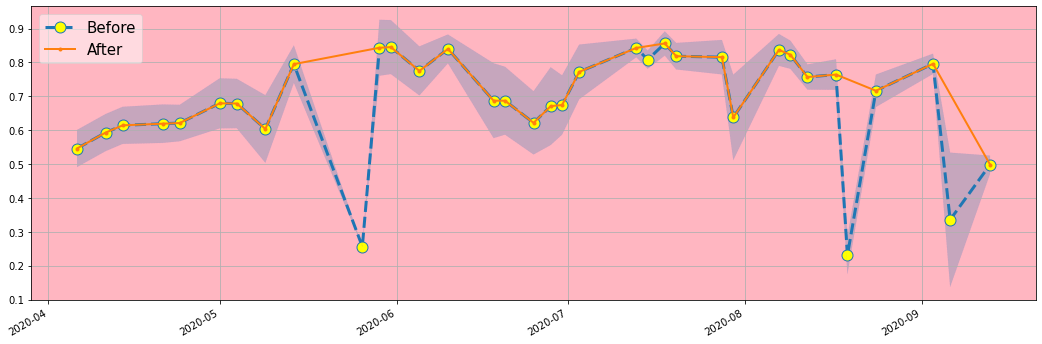

In [13]:
### EXAMPLE CASE

case_to_check = 150

fig,ax = plt.subplots(figsize=(18,6))

ndvi_case = df.iloc[case_to_check].copy()
lower_bound = pd.Series(data=ndvi_case.values-fs_std[case_to_check][0],index=ndvi_case.index)
lower_bound.loc[ndvi_case[ndvi_case.isna()].index] = np.nan
upper_bound = pd.Series(data=ndvi_case.values+fs_std[case_to_check][0],index=ndvi_case.index)
upper_bound.loc[ndvi_case[ndvi_case.isna()].index] = np.nan
ndvi_case.dropna().plot(marker='.',label='Before',markersize=22,lw=3,ls='--',markerfacecolor='yellow') 
lower_bound.dropna().plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
upper_bound.dropna().plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
ax.fill_between(x=lower_bound.dropna().index, y1=lower_bound.dropna(), y2 = upper_bound.dropna(), alpha=0.25, 
                cmap=plt.cm.get_cmap("winter"))
(restore_picture(df.iloc[case_to_check].copy())).dropna().plot(marker='.',label='After',lw=2)
ax.set_facecolor('lightpink')
plt.legend(fontsize=15,fancybox=True,framealpha=0.5,loc='upper left')
plt.grid()
plt.show()

In [14]:
%%time
df = df.apply(lambda row:restore_picture(row),axis=1)

CPU times: user 1min 14s, sys: 1.28 s, total: 1min 16s
Wall time: 1min 15s


## Mowing Detection

<img src='https://creodias.eu/image/journal/article?img_id=106955&t=1641652402239'/>

For the mowing detection we re-produced a simple version of the respective methodology developed by [SEN4CAP](http://esa-sen4cap.org/). This methodology is based entirely on NDVI  time-series and it takes into account: 
* the existence of NDVI difference between two consecutive valid measurements that is greater than a pre-defined threshold (*ndvi_gap_param*)
* a slope smaller than a specific value in order to exclude very abrupt changes that probably owed to potential not detected from the masks clouds (*slope_param*)

In [15]:
%%time
ndvi_gap_param = 0.1
slope_param = 0.05
MD = Mowing_Detection()
mowing_results = MD.predict(df.copy(),threshold=ndvi_gap_param,min_rate= slope_param)
print(mowing_results.shape)
mowing_results.head()

(8668, 16)
CPU times: user 33.1 s, sys: 322 ms, total: 33.4 s
Wall time: 33.4 s


,mow_n,m1_dstart,m1_dend,m1_conf,m2_dstart,m2_dend,m2_conf,m3_dstart,m3_dend,m3_conf,m4_dstart,m4_dend,m4_conf,m5_dstart,m5_dend,m5_conf
0,2.0,2020-06-10 00:00:00,2020-06-20 00:00:00,0.298682,2020-08-24 00:00:00,2020-09-03 00:00:00,0.259863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2020-05-31 00:00:00,2020-06-08 00:00:00,0.072852,2020-09-06 00:00:00,2020-09-11 00:00:00,0.015234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2020-04-21 00:00:00,2020-05-09 00:00:00,0.154883,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
mowing_results['NDVI_mean'] = df.mean(axis=1)
mowing_results['NDVI_max'] = df.max(axis=1)
mowing_results['Parcel_ID'] = ids.copy()

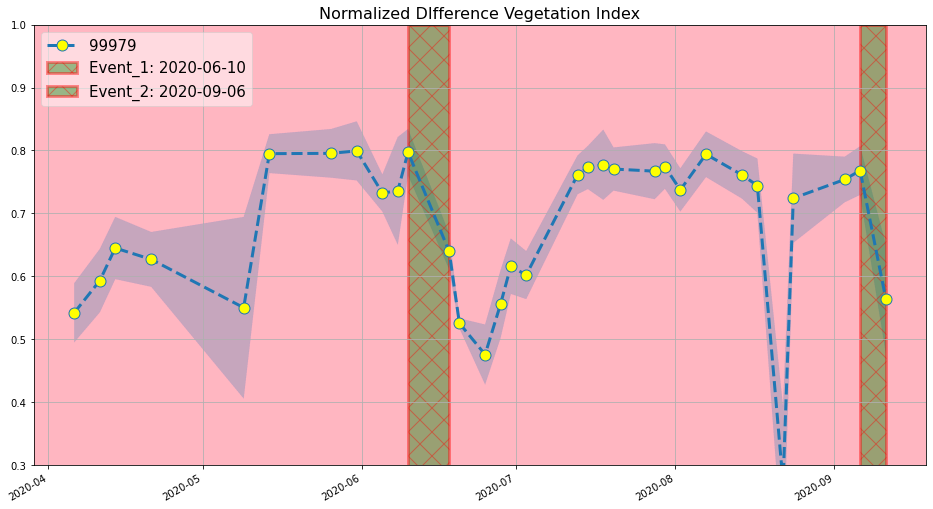

In [17]:
### EXAMPLE CASE

case_to_check = 31

fig,ax = plt.subplots(figsize=(16,9))


ndvi_case = df.iloc[case_to_check].copy()
lower_bound = pd.Series(data=ndvi_case.values-fs_std[case_to_check][0],index=ndvi_case.index)
lower_bound.loc[ndvi_case[ndvi_case.isna()].index] = np.nan
upper_bound = pd.Series(data=ndvi_case.values+fs_std[case_to_check][0],index=ndvi_case.index)
upper_bound.loc[ndvi_case[ndvi_case.isna()].index] = np.nan
ndvi_case.dropna().plot(marker='.',label=ids[case_to_check],markersize=22,lw=3,ls='--',markerfacecolor='yellow') 
lower_bound.dropna().plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
upper_bound.dropna().plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
ax.fill_between(x=lower_bound.dropna().index, y1=lower_bound.dropna(), y2 = upper_bound.dropna(), alpha=0.25, 
                cmap=plt.cm.get_cmap("winter"))

s_dates = mowing_results.iloc[case_to_check].filter(regex='dstart').values
e_dates = mowing_results.iloc[case_to_check].filter(regex='dend').values
for n,v in enumerate(s_dates):
    if v!=0:
        plt.fill_between([s_dates[n],e_dates[n]],[1,1],
                         linewidth=3,edgecolor='red',facecolor='green',hatch='x',alpha=0.4,
                         label='Event_{}: {}'.format(n+1,v.date()))
ax.set_facecolor('lightpink')
plt.legend(fontsize=15,fancybox=True,framealpha=0.5,loc='upper left')
plt.title('Normalized DIfference Vegetation Index',fontsize=16)
plt.ylim(0.3,1)
plt.grid()
plt.show()

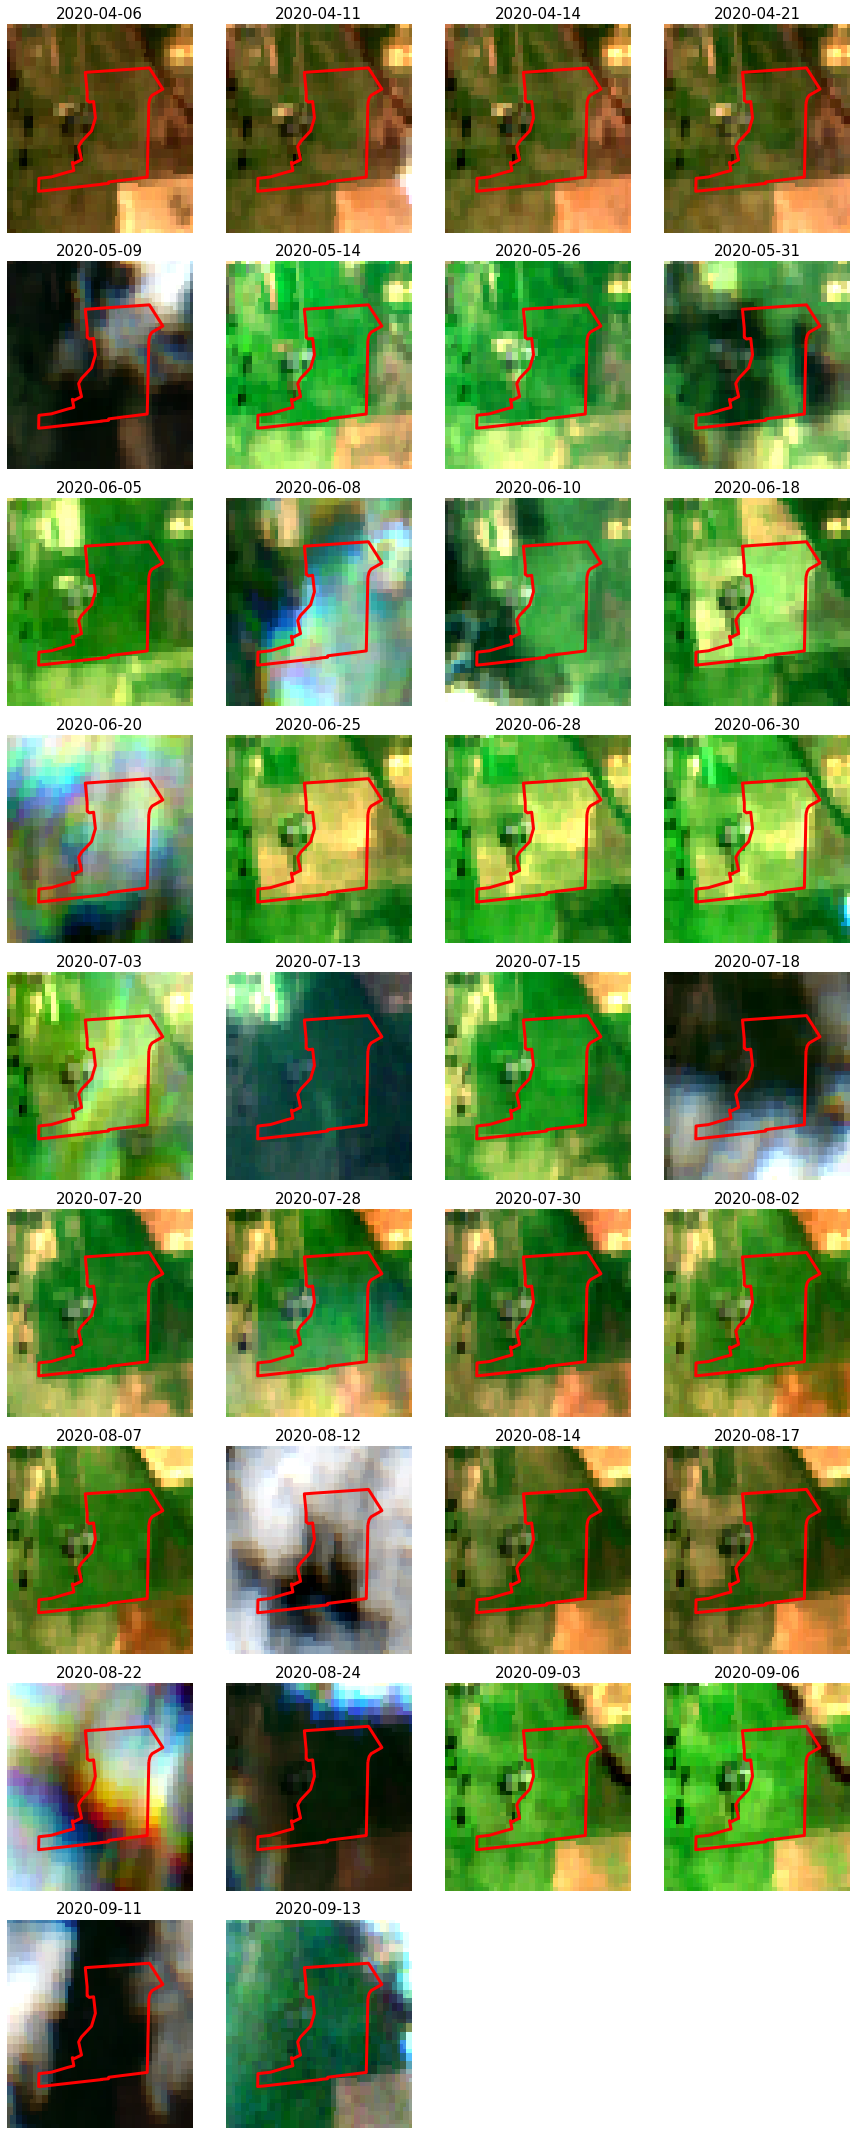

In [18]:
photo_interpretation(path_decl,ids[case_to_check],start_date,end_date)

## Quantify grassland use intensity

#### Here we can see some analytics regarding the results acquired

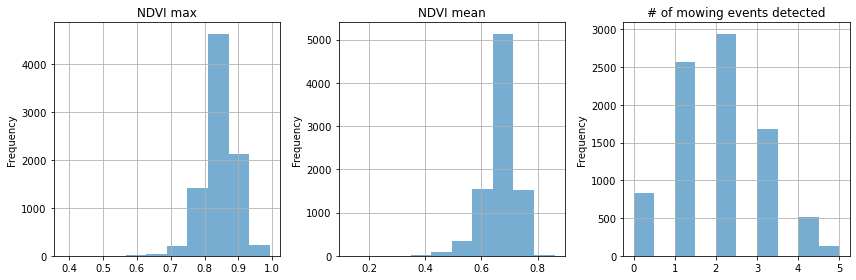

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))

mowing_results['NDVI_max'].plot.hist(ax=ax[0],alpha=0.6)
ax[0].set_title('NDVI max')
ax[0].grid()
mowing_results['NDVI_mean'].plot.hist(ax=ax[1],alpha=0.6)
ax[1].set_title('NDVI mean')
ax[1].grid()
mowing_results['mow_n'].plot.hist(ax=ax[2],alpha=0.6)
ax[2].set_title('# of mowing events detected')
ax[2].grid()
plt.tight_layout()
plt.show()

Limit the results with grassland fields with:
* Average NDVI < 0.6
* Maximum NDVI < 0.75
* Number of events detected > 1
* These events should be detected between **2020-06-01** and **2020-08-01**

In [20]:
d_start = '2020-06-01'
d_end = '2020-08-01'
cond_1 = mowing_results['m1_dstart'].apply(lambda x:pd.to_datetime(x).dayofyear)<pd.to_datetime(datetime.strptime(d_end,'%Y-%m-%d')).dayofyear
cond_2 = mowing_results['m1_dstart'].apply(lambda x:pd.to_datetime(x).dayofyear)>pd.to_datetime(datetime.strptime(d_start,'%Y-%m-%d')).dayofyear
cond_3 = (mowing_results['mow_n']>1)
cond_4 = (mowing_results['NDVI_max']<0.75)
cond_5 = (mowing_results['NDVI_mean']<0.6)
cases = mowing_results[cond_1&cond_2&cond_3&cond_4&cond_5]
print(cases.shape)
cases.head()

(53, 19)


,mow_n,m1_dstart,m1_dend,m1_conf,m2_dstart,m2_dend,m2_conf,m3_dstart,m3_dend,m3_conf,m4_dstart,m4_dend,m4_conf,m5_dstart,m5_dend,m5_conf,NDVI_mean,NDVI_max,Parcel_ID
41,5.0,2020-06-10 00:00:00,2020-06-15 00:00:00,0.036230,2020-06-20 00:00:00,2020-06-25 00:00:00,0.004492,2020-07-20 00:00:00,2020-07-23 00:00:00,0.018652,2020-08-07 00:00:00,2020-08-12 00:00:00,0.034277,2020-08-17 00:00:00,2020-08-24 00:00:00,0.11228,0.508301,0.696777,101561
156,2.0,2020-06-20 00:00:00,2020-06-25 00:00:00,0.031348,2020-09-06 00:00:00,2020-09-13 00:00:00,0.091895,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.562500,0.722168,142254
577,3.0,2020-06-10 00:00:00,2020-06-18 00:00:00,0.209570,2020-07-30 00:00:00,2020-08-02 00:00:00,0.024512,2020-09-06 00:00:00,2020-09-11 00:00:00,0.031104,0.0,0.0,0.000000,0.0,0.0,0.00000,0.520508,0.705566,249217
585,3.0,2020-06-10 00:00:00,2020-06-18 00:00:00,0.161719,2020-07-20 00:00:00,2020-07-28 00:00:00,0.142187,2020-07-30 00:00:00,2020-08-02 00:00:00,0.018164,0.0,0.0,0.000000,0.0,0.0,0.00000,0.489746,0.655273,249228
700,3.0,2020-06-18 00:00:00,2020-06-25 00:00:00,0.070410,2020-07-20 00:00:00,2020-07-23 00:00:00,0.045020,2020-09-06 00:00:00,2020-09-11 00:00:00,0.041357,0.0,0.0,0.000000,0.0,0.0,0.00000,0.576660,0.732422,254970


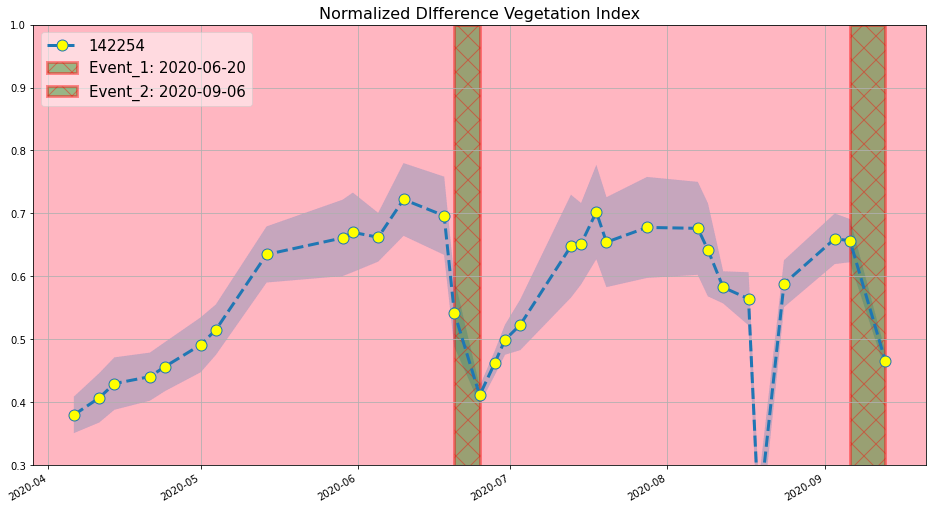

In [21]:
### EXAMPLE CASE

case_to_check = 156

fig,ax = plt.subplots(figsize=(16,9))


ndvi_case = df.iloc[case_to_check].copy()
lower_bound = pd.Series(data=ndvi_case.values-fs_std[case_to_check][0],index=ndvi_case.index)
lower_bound.loc[ndvi_case[ndvi_case.isna()].index] = np.nan
upper_bound = pd.Series(data=ndvi_case.values+fs_std[case_to_check][0],index=ndvi_case.index)
upper_bound.loc[ndvi_case[ndvi_case.isna()].index] = np.nan
ndvi_case.dropna().plot(marker='.',label=ids[case_to_check],markersize=22,lw=3,ls='--',markerfacecolor='yellow') 
lower_bound.dropna().plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
upper_bound.dropna().plot(label='',lw=0.5,ls='--',color='b',alpha=0.05,legend=False,ax=ax)
ax.fill_between(x=lower_bound.dropna().index, y1=lower_bound.dropna(), y2 = upper_bound.dropna(), alpha=0.25, 
                cmap=plt.cm.get_cmap("winter"))

s_dates = mowing_results.iloc[case_to_check].filter(regex='dstart').values
e_dates = mowing_results.iloc[case_to_check].filter(regex='dend').values
for n,v in enumerate(s_dates):
    if v!=0:
        plt.fill_between([s_dates[n],e_dates[n]],[1,1],
                         linewidth=3,edgecolor='red',facecolor='green',hatch='x',alpha=0.4,
                         label='Event_{}: {}'.format(n+1,v.date()))
ax.set_facecolor('lightpink')
plt.legend(fontsize=15,fancybox=True,framealpha=0.5,loc='upper left')
plt.title('Normalized DIfference Vegetation Index',fontsize=16)
plt.ylim(0.3,1)
plt.grid()
plt.show()

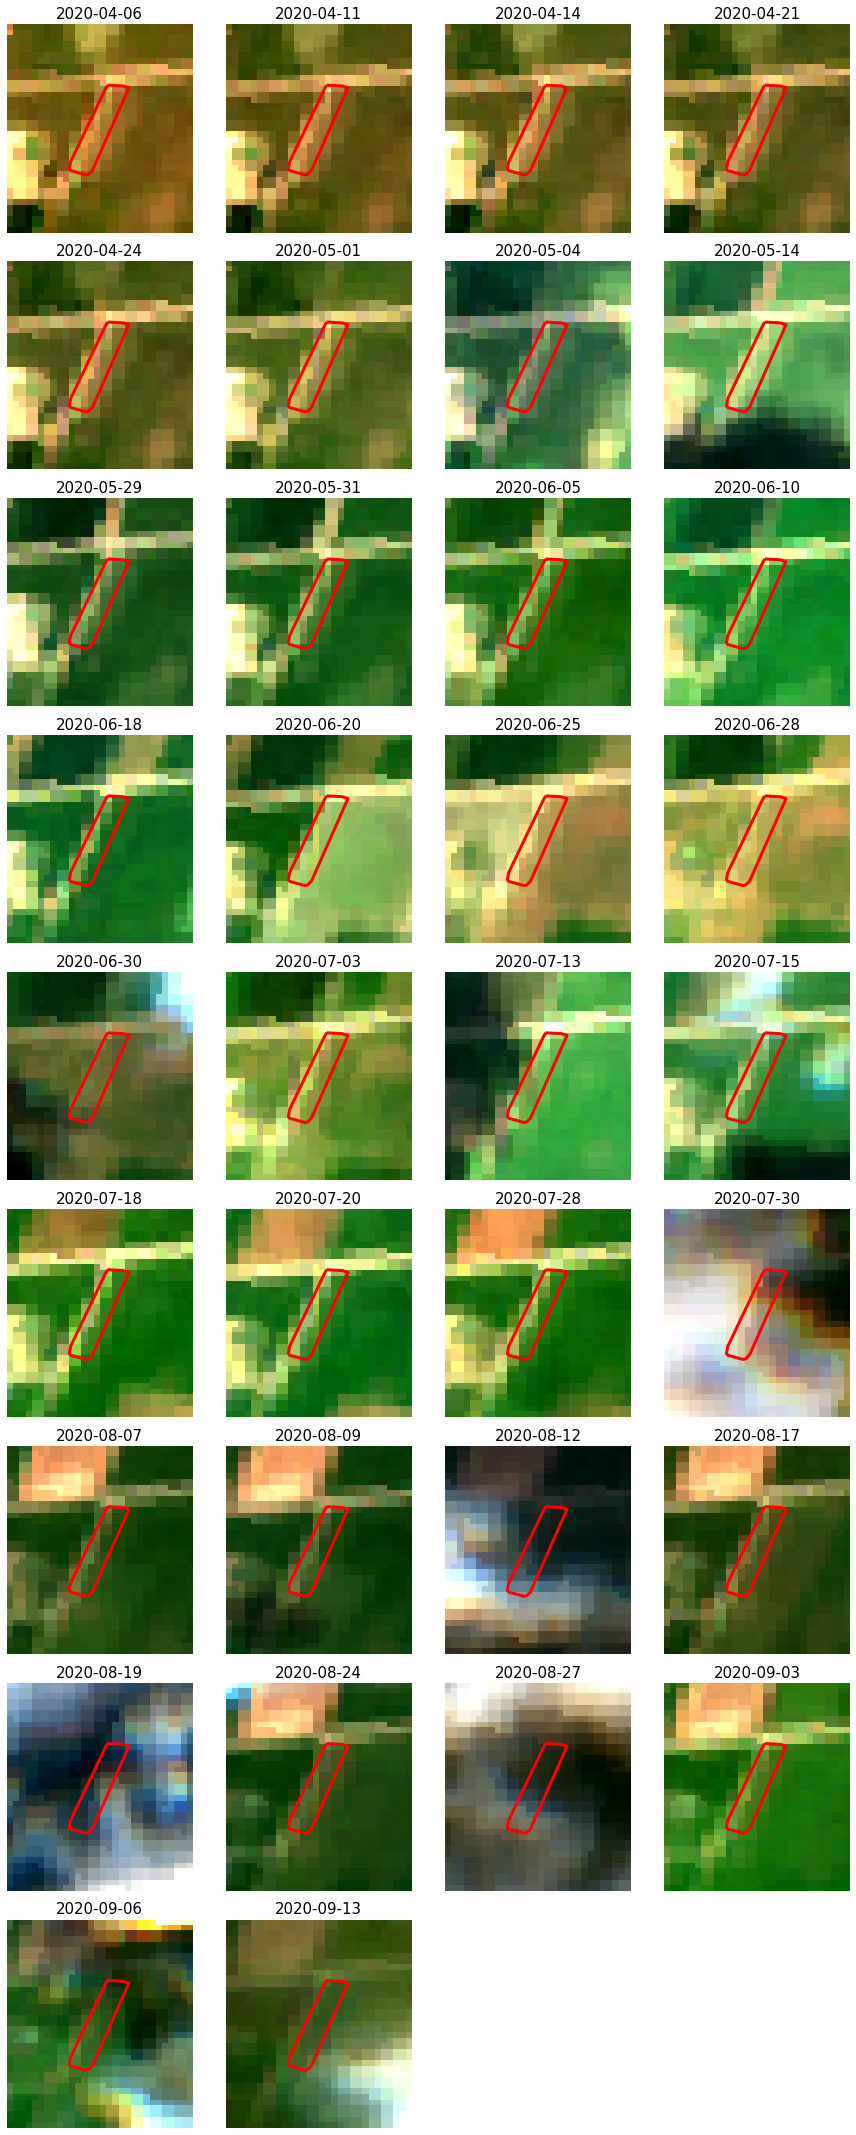

In [22]:
photo_interpretation(path_decl,ids[case_to_check],start_date,end_date)